In [33]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.estimator_checks import check_estimator

from data import *
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

sklearn.set_config(display="diagram")
sklearn.set_config(transform_output="pandas")

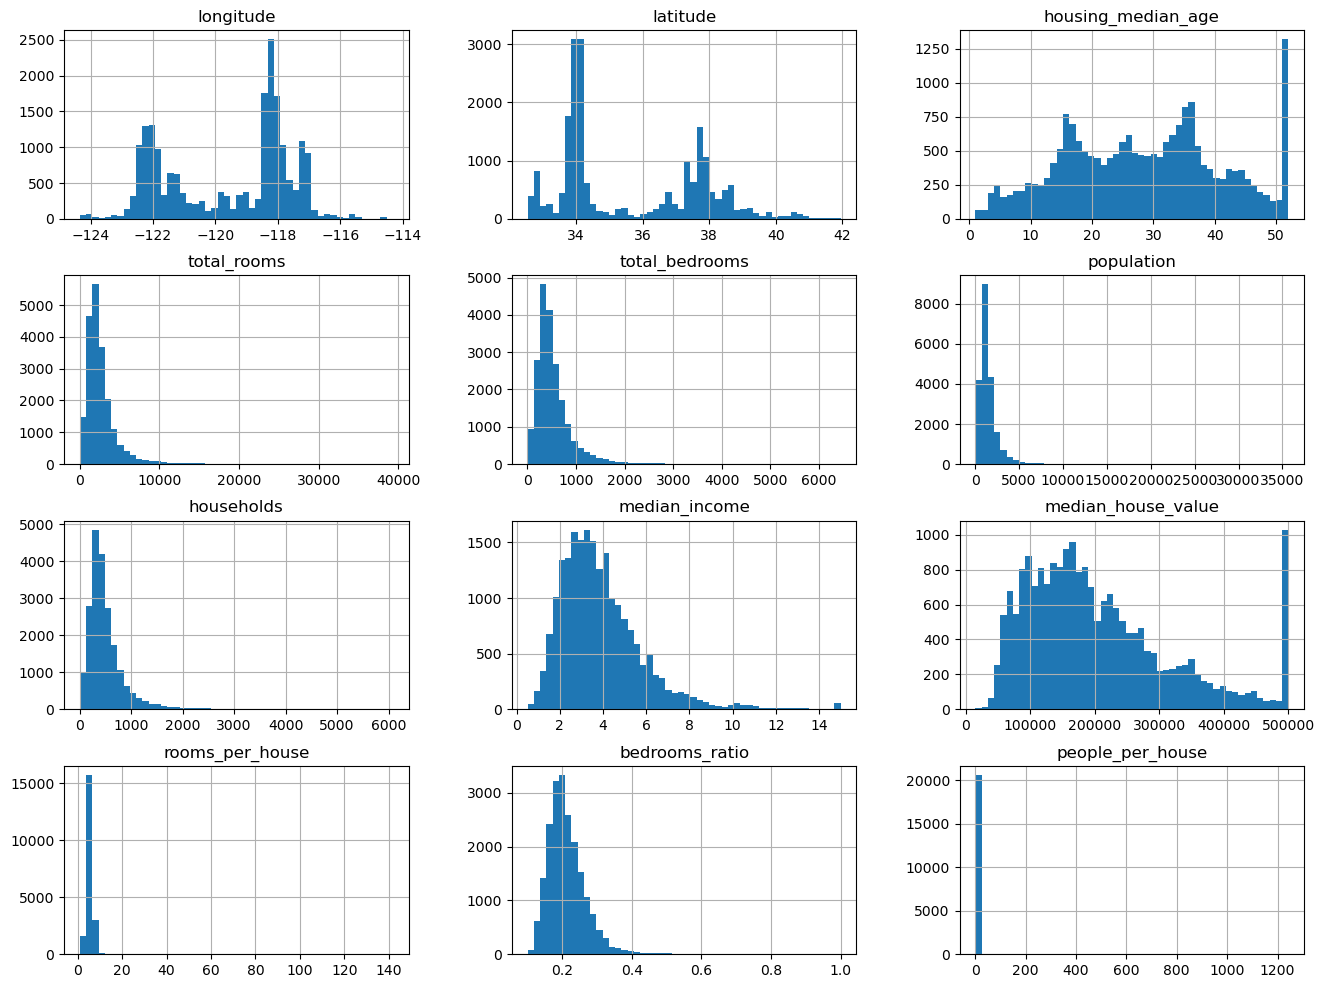

In [34]:
raw["rooms_per_house"] = raw["total_rooms"] / raw["households"]
raw["bedrooms_ratio"] = raw["total_bedrooms"] / raw["total_rooms"]
raw["people_per_house"] = raw["population"] / raw["households"]
raw.hist(bins=50, figsize=(16, 12))
display()

In [35]:
raw["income_cat"] = pd.cut(raw["median_income"], bins=[0, 1.5, 3, 4.5, 6, np.inf], right=False, labels=["A: 0-1.5", "B: 1.5-3", "C: 3-4.5", "D: 4.5-6", "E: 6+"])


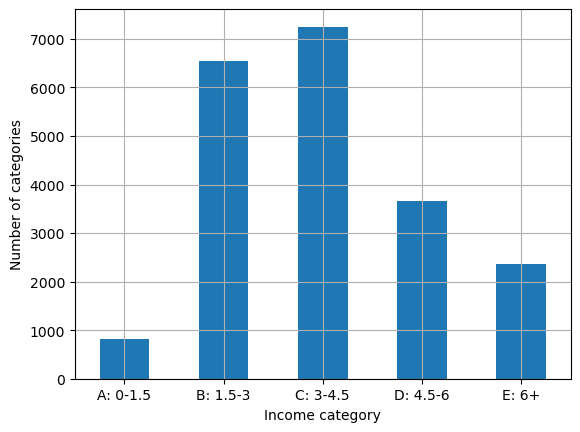

In [36]:
series = raw["income_cat"].value_counts()
ax = series.sort_index().plot.bar(rot=0, grid=True)
ax.set_xlabel("Income category")
ax.set_ylabel("Number of categories")
display()

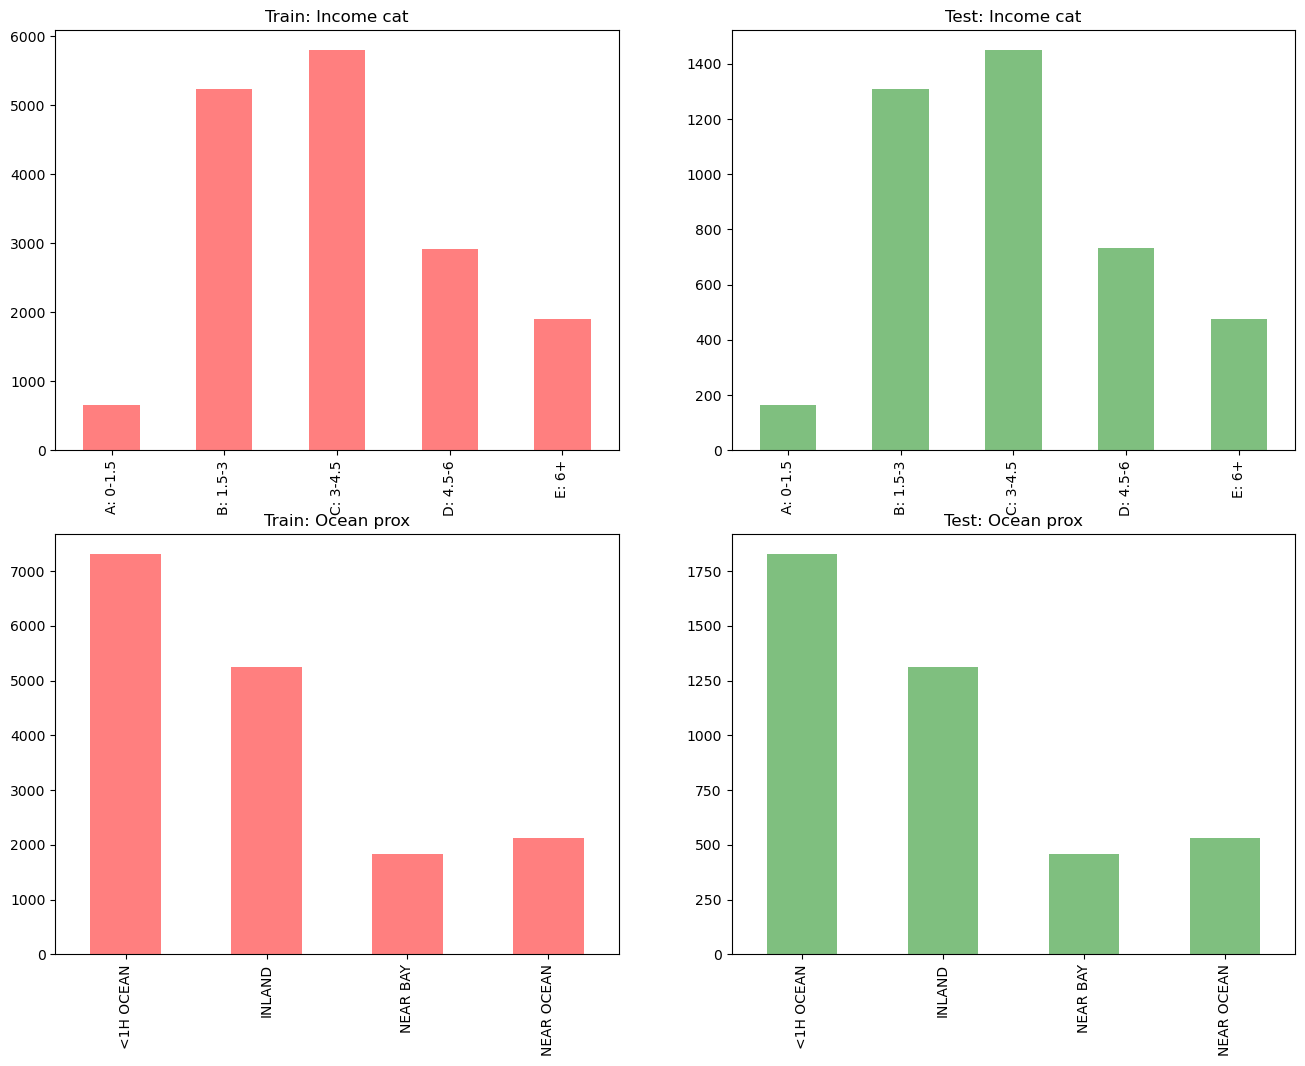

In [37]:
housing = raw[raw["ocean_proximity"] != 'ISLAND'].copy()
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
train_i, test_i = list(splitter.split(housing, housing[["income_cat", "ocean_proximity"]]))[0]
train = housing.iloc[train_i].copy()
test = housing.iloc[test_i].copy()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
(train["income_cat"].value_counts()).sort_index().plot.bar(ax=ax1, alpha=0.5, color="r", title="Train: Income cat")
(test["income_cat"].value_counts()).sort_index().plot.bar(ax=ax2, alpha=0.5, color="g", title="Test: Income cat")
(train["ocean_proximity"].value_counts()).sort_index().plot.bar(ax=ax3, alpha=0.5, color="r", title="Train: Ocean prox")
(test["ocean_proximity"].value_counts()).sort_index().plot.bar(ax=ax4, alpha=0.5, color="g", title="Test: Ocean prox")
display()

housing.drop("income_cat", inplace=True, axis=1)
train.drop("income_cat", inplace=True, axis=1)
test.drop("income_cat", inplace=True, axis=1)

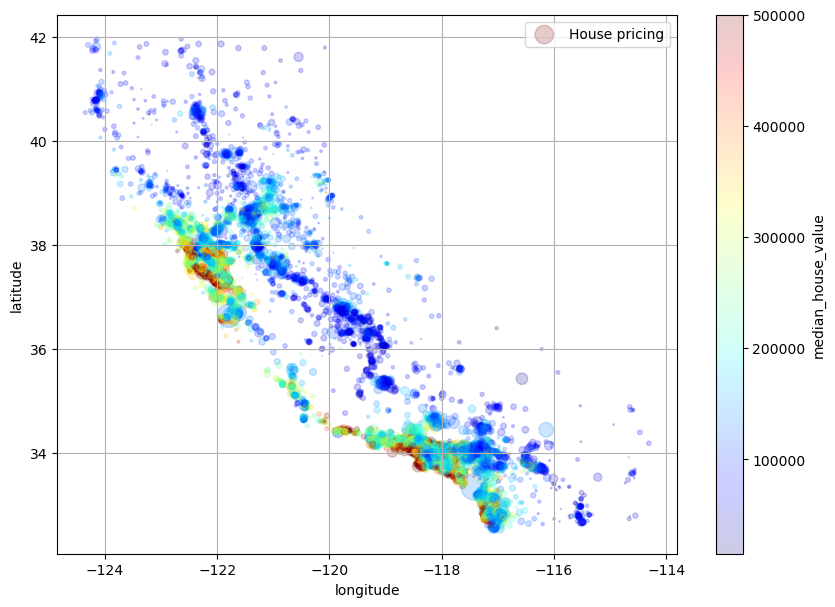

In [38]:
train.plot.scatter(x="longitude", y="latitude", grid=True, alpha=0.2, s=train["population"] / 100, c="median_house_value", cmap="jet", figsize=(10, 7), label="House pricing")
display()

In [39]:
train.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688993
rooms_per_house       0.162615
total_rooms           0.134368
housing_median_age    0.109540
households            0.065382
total_bedrooms        0.050728
population           -0.026291
people_per_house     -0.039160
longitude            -0.045169
latitude             -0.143859
bedrooms_ratio       -0.259311
Name: median_house_value, dtype: float64

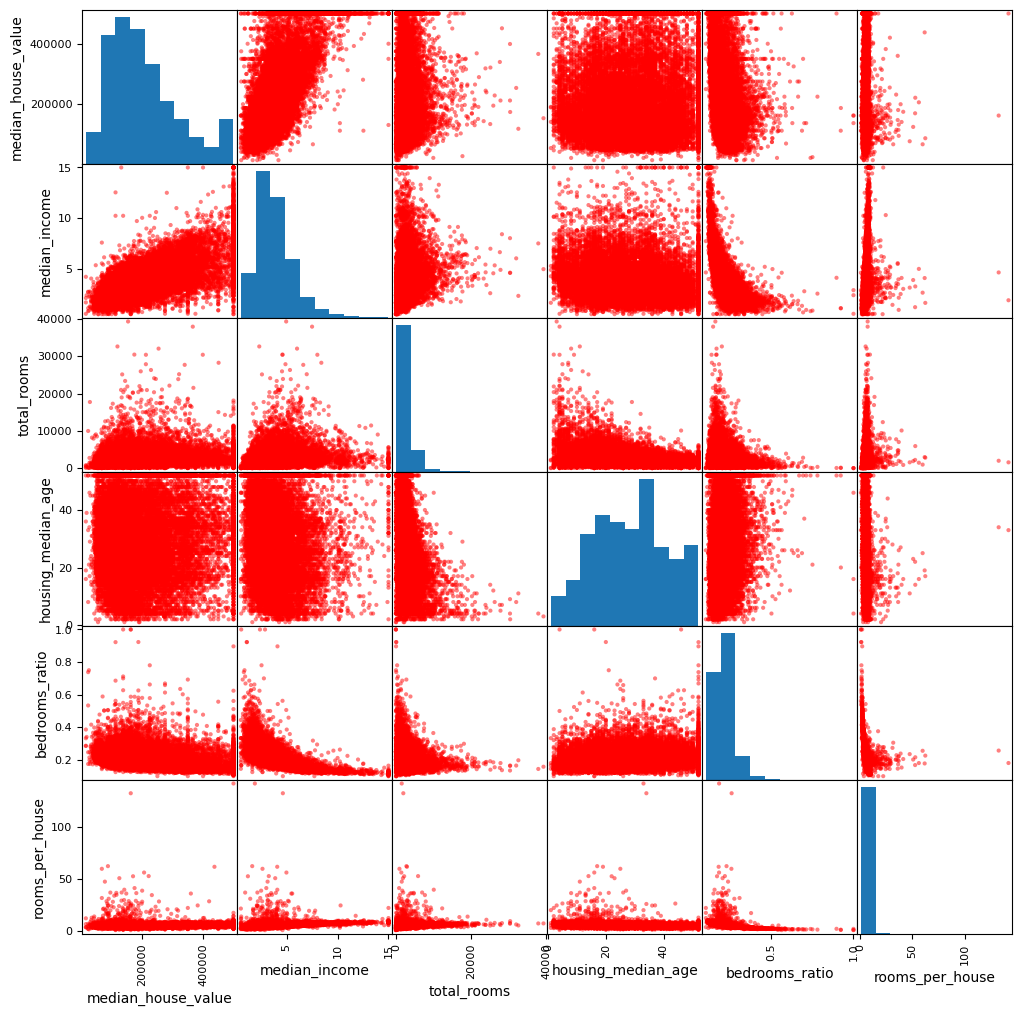

In [40]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing[["median_house_value", "median_income", "total_rooms", "housing_median_age", "bedrooms_ratio", "rooms_per_house"]], figsize=(12, 12), color="r")
display()

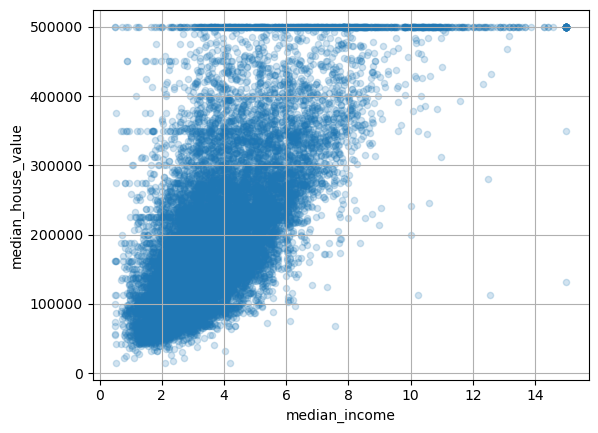

In [41]:
train.plot.scatter(x="median_income", y="median_house_value", alpha=0.2, grid=True)
display()

In [42]:
inputs = train.drop(["median_house_value", "rooms_per_house", "bedrooms_ratio", "people_per_house"], axis=1)
labels = train["median_house_value"].copy()
inputs

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
8019,-118.48,34.05,36.0,2143.0,434.0,751.0,396.0,6.7496,<1H OCEAN
2335,-122.48,37.74,52.0,2285.0,435.0,1211.0,442.0,4.0208,NEAR OCEAN
1247,-122.44,37.78,31.0,1364.0,386.0,707.0,379.0,3.1607,NEAR BAY
19038,-117.01,32.74,31.0,3473.0,NaN,2098.0,677.0,2.6973,<1H OCEAN
10336,-122.55,38.81,7.0,3639.0,637.0,1027.0,421.0,3.8831,INLAND
...,...,...,...,...,...,...,...,...,...
6861,-122.43,37.75,52.0,2700.0,595.0,1181.0,575.0,3.5750,NEAR BAY
6363,-121.95,37.32,39.0,1164.0,199.0,619.0,231.0,4.6304,<1H OCEAN
2519,-117.33,34.03,18.0,2342.0,402.0,1264.0,382.0,4.7986,INLAND
4441,-118.01,33.77,32.0,1771.0,296.0,995.0,272.0,5.8362,<1H OCEAN


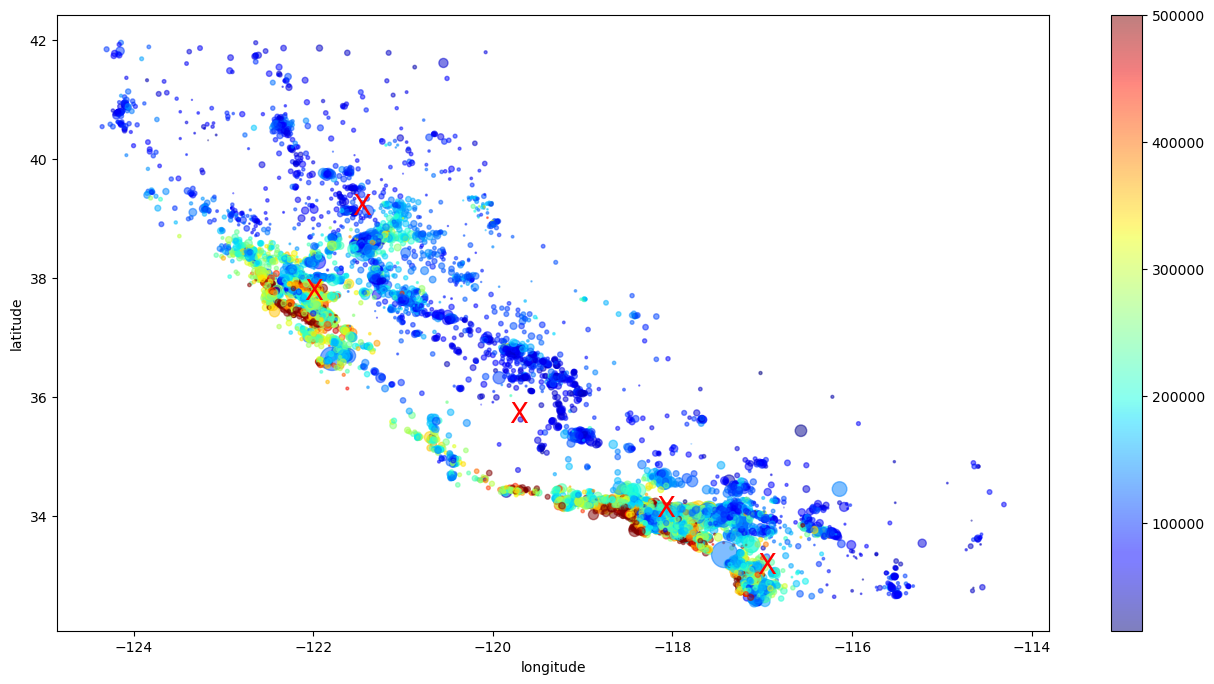

In [43]:
# Playing a bit with KMeans
fig, ax = plt.subplots(figsize=(16, 8))

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans.fit(inputs[["longitude", "latitude"]], sample_weight=labels)

inputs.plot.scatter(ax=ax, x="longitude", y="latitude", s=inputs["population"] / 100, c=labels, cmap="jet", alpha=0.5)

for (x, y) in kmeans.cluster_centers_:
    ax.annotate("X", xy=(x, y), color="red", size=20)


In [44]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state, n_init='auto')
        self.kmeans_.fit(X, sample_weight=y)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return ["Cluster {} similarity".format(i) for i in range(self.n_clusters)]

ratio = FunctionTransformer(lambda X: X.iloc[:, 0] / X.iloc[:, 1], feature_names_out=lambda tf, inp: ["ratio"])
log = FunctionTransformer(np.log, feature_names_out="one-to-one")
simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse_output=False, handle_unknown="ignore")
)

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    ColumnTransformer([
        ("rooms_per_house", ratio, ["total_rooms", "households"]),
        ("bedrooms_per_room", ratio, ["total_bedrooms", "total_rooms"]),
        ("people_per_house", ratio, ["population", "households"]),
        ("log", log, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("geo", simil, ["latitude", "longitude"])
    ], remainder="passthrough"),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("num", numerical_pipeline, make_column_selector(dtype_include=np.number)),
    ("cat", cat_pipeline, make_column_selector(dtype_exclude=np.number)),
])

housing_prepared = preprocessing.fit_transform(inputs, labels)
list(preprocessing.get_feature_names_out())
# housing_prepared

['num__rooms_per_house__ratio',
 'num__bedrooms_per_room__ratio',
 'num__people_per_house__ratio',
 'num__log__total_bedrooms',
 'num__log__total_rooms',
 'num__log__population',
 'num__log__households',
 'num__log__median_income',
 'num__geo__Cluster 0 similarity',
 'num__geo__Cluster 1 similarity',
 'num__geo__Cluster 2 similarity',
 'num__geo__Cluster 3 similarity',
 'num__geo__Cluster 4 similarity',
 'num__geo__Cluster 5 similarity',
 'num__geo__Cluster 6 similarity',
 'num__geo__Cluster 7 similarity',
 'num__geo__Cluster 8 similarity',
 'num__geo__Cluster 9 similarity',
 'num__remainder__housing_median_age',
 'cat__ocean_proximity_<1H OCEAN',
 'cat__ocean_proximity_INLAND',
 'cat__ocean_proximity_NEAR BAY',
 'cat__ocean_proximity_NEAR OCEAN']

In [45]:
lin_reg = make_pipeline(
    preprocessing,
    LinearRegression()
)

lin_reg.fit(inputs, labels)
predictions = lin_reg.predict(inputs)
lin_rmse = mean_squared_error(labels, predictions, squared=False)
lin_rmse
# y_hat = pd.Series(lin_reg.predict(inputs), name="y_hat", index=inputs.index)
# pd.concat([inputs, labels, y_hat, (abs(y_hat-labels)).rename("abs_errors")], axis=1)

68967.21217375586

In [46]:
# Looks like overfitting!
tree_reg = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(random_state=42)
)
tree_reg.fit(inputs, labels)
predictions = tree_reg.predict(inputs)
lin_rmse = mean_squared_error(labels, predictions, squared=False)
lin_rmse

0.0

In [47]:
# 10-fold cross-validation (automatically fits on 9 strata and validates against the 10th)
tree_rmses = -cross_val_score(tree_reg, inputs, labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     67435.653979
std       2671.935177
min      61572.551866
25%      66434.233770
50%      67950.398793
75%      69285.526051
max      70600.127971
dtype: float64

In [48]:
forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

forest_rmses = -cross_val_score(forest_reg, inputs, labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     47280.780383
std       1580.246018
min      44578.104290
25%      46145.723599
50%      47621.970376
75%      47954.856122
max      49941.632707
dtype: float64

In [57]:
forest_reg.fit(inputs, labels)
y_hat = forest_reg.predict(inputs)
forest_rmse = mean_squared_error(labels, y_hat, squared=False)
forest_rmse

16.1 s ± 91.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

# Run this to get a list of possible hyper-parameters to tune!
# full_pipeline.get_params()
param_grid = [
    {
        "preprocessing__num__columntransformer__geo__n_clusters": [5, 8, 10],
        "random_forest__max_features": [4, 6, 8]
    }, {
        "preprocessing__num__columntransformer__geo__n_clusters": [10, 15],
        "random_forest__max_features": [6, 8, 10]
    }
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(inputs, labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('rooms_per_house',
                                                                                                                           FunctionTransformer(feature_names_out=<function <lambda> at 0x7fdbd6eb3400>,
                                                                                                                                               func=<function...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdbcc6e9b70>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__num__columntransformer__geo__n_clusters': [5,
                                                                                     8,
                                                                                     10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__num__columntransformer__geo__n_clusters': [10,
                                                                                     15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [51]:
grid_search.best_estimator_.fit(inputs, labels)
y_hat = grid_search.best_estimator_.predict(inputs)
display(mean_squared_error(labels, y_hat, squared=False))
grid_search.best_params_

16260.549819503854

{'preprocessing__num__columntransformer__geo__n_clusters': 15,
 'random_forest__max_features': 6}

In [52]:
df = pd.DataFrame(grid_search.cv_results_)
df[["n_clusters", "max_features"]] = df["params"].apply(lambda x: pd.Series([x['preprocessing__num__columntransformer__geo__n_clusters'], x['random_forest__max_features']]))
df.rename(columns={"split0_test_score": "split0", "split1_test_score": "split1", "split2_test_score": "split2"}, inplace=True)
df["mean_test_rmse"] = -df["mean_test_score"]

df[["n_clusters", "max_features", "split0", "split1", "split2", "mean_test_rmse"]].sort_values(by="mean_test_rmse")

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,-43912.916989,-44444.110954,-44987.193518,44448.073820
13,15,8,-44191.529998,-44997.407309,-45343.980366,44844.305891
14,15,10,-44688.553561,-45271.923255,-45821.373547,45260.616788
6,10,4,-45066.057553,-45841.611389,-46211.126617,45706.265186
7,10,6,-45006.520236,-45874.550445,-46453.164864,45778.078515
9,10,6,-45006.520236,-45874.550445,-46453.164864,45778.078515
8,10,8,-45512.106614,-46071.217654,-46534.417837,46039.247368
10,10,8,-45512.106614,-46071.217654,-46534.417837,46039.247368
3,8,4,-45333.898545,-46228.360109,-46775.838403,46112.699019
4,8,6,-45524.730697,-46414.598555,-46637.901949,46192.410400


In [53]:
final_model = grid_search.best_estimator_
rnd = final_model["random_forest"]
pd.DataFrame(zip(rnd.feature_names_in_, rnd.feature_importances_), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)

,feature,importance
7,num__log__median_income,0.259839
25,cat__ocean_proximity_INLAND,0.099551
2,num__people_per_house__ratio,0.069048
1,num__bedrooms_per_room__ratio,0.065257
10,num__geo__Cluster 2 similarity,0.052672
0,num__rooms_per_house__ratio,0.051666
18,num__geo__Cluster 10 similarity,0.035382
19,num__geo__Cluster 11 similarity,0.034427
9,num__geo__Cluster 1 similarity,0.034081
21,num__geo__Cluster 13 similarity,0.029798


In [54]:
test_x = test.drop(["median_house_value", "rooms_per_house", "bedrooms_ratio", "people_per_house"], axis=1)
test_y = test["median_house_value"].copy()

y_hat = final_model.predict(test_x)
mean_squared_error(test_y, y_hat, squared=False)

41278.57381283966

In [55]:
from scipy import stats
squared_errors = (test_y - y_hat) ** 2
np.sqrt(stats.t.interval(0.95, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([39283.69385142, 43181.39309277])

In [56]:
import joblib
joblib.dump(final_model, "house_pricing_model.pkl")

PicklingError: Can't pickle <function <lambda> at 0x7fdbd75acca0>: it's not found as __main__.<lambda>